In [ ]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.8 MB/s 


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 
import keras
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Flatten, Input 
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np
import pandas as pd 


In [ ]:
dff= pd.read_csv('/content/drive/MyDrive/data1/phishing_site_urls.csv' , sep = ',')

In [ ]:
dff.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
def to_zero_andone(data):
    for idx, val in enumerate(data):
        if str(val) == "bad":
            output_x[idx] = 1
        elif str(val) == "good":
            output_x[idx] = 0
    return data

In [ ]:
dataset = dff.values
x = dff['URL']
y = dff['Label']
output_x=dataset[:,-1]
output_x=to_zero_andone(output_x) 

In [ ]:
dff.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [ ]:
print(x.shape)
print(y.shape)

(549346,)
(549346,)


In [ ]:
validation_size = 0.1
test_size = 0.25
x_train, x_test, y_train, y_test = train_test_split(x ,y, test_size=test_size)
x_train, x_validation, y_train, y_validation = train_test_split(x_train ,y_train, test_size=validation_size)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(370808,)
(370808,)
(41201,)
(41201,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj=Tokenizer()
text_urls= pd.concat([x_train , x_validation],axis=0).astype("str")
tokenizer_obj.fit_on_texts(text_urls)


In [ ]:
#pad sequences
max_length=300

In [ ]:
#vocabulary size
vocab_size=len(tokenizer_obj.word_index)+1

In [ ]:
x_train_tokens=tokenizer_obj.texts_to_sequences(x_train)
x_validation_tokens=tokenizer_obj.texts_to_sequences(x_validation)

x_train_pad=pad_sequences(x_train_tokens,maxlen=max_length)
x_validation_pad=pad_sequences(x_validation_tokens,maxlen=max_length)

In [ ]:
from tqdm import tqdm
embedding_vector = {}
f = open('/content/drive/MyDrive/data1/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

2196018it [02:11, 16678.11it/s]


In [ ]:
embedding_matrix = np.zeros((vocab_size,max_length))
for word,i in tqdm(tokenizer_obj.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 398536/398536 [00:00<00:00, 858387.62it/s]


In [ ]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

def define_model(kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    inp = Input( shape=(max_length,))
    x = Embedding(vocab_size,max_length,weights = [embedding_matrix],input_length=max_length,trainable = False)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(2, activation="softmax")(conc)    
    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [ ]:
model_0 = define_model( input_dim=100, max_length=max_length)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_validation = to_categorical(y_validation, 2)

In [ ]:
#SGD
history = model_0.fit(x_train_pad, y_train, validation_data=(x_validation_pad, y_validation), epochs=10,batch_size=1000,verbose=1)

Epoch 1/10
371/371 [==============================] - 226s 557ms/step - loss: 0.1856 - accuracy: 0.9273 - val_loss: 0.1188 - val_accuracy: 0.9559
Epoch 2/10
371/371 [==============================] - 209s 562ms/step - loss: 0.1129 - accuracy: 0.9591 - val_loss: 0.1042 - val_accuracy: 0.9624
Epoch 3/10
153/371 [===========>..................] - ETA: 1:56 - loss: 0.0969 - accuracy: 0.9647

In [ ]:
score = model_0.evaluate(x_validation_pad, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12423298507928848
Test accuracy: 0.9531371593475342


In [ ]:
from sklearn.metrics import roc_auc_score
preds = model_0.predict(x_validation_pad)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_validation)
print("AUC: {:.2%}".format (auc))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 94.56%


In [ ]:
from sklearn.metrics import confusion_matrix
y_predict=np.argmax(y_pred,axis=-1)
yval=np.argmax(y_validation,axis=-1)
cnf_matrix = confusion_matrix(y_predict, yval)
cnf_matrix

array([[95540,  3726],
       [ 2710, 35361]])

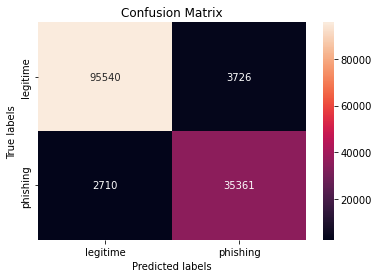

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax,fmt="d");
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['legitime','phishing']);
ax.yaxis.set_ticklabels(['legitime','phishing']);

In [ ]:
from sklearn.metrics import classification_report
target_names = ['legitime', 'phishing']
print(classification_report(yval, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    legitime       0.96      0.97      0.97     98250
    phishing       0.93      0.90      0.92     39087

    accuracy                           0.95    137337
   macro avg       0.95      0.94      0.94    137337
weighted avg       0.95      0.95      0.95    137337



*****************************************************************************************************************************************************************************************************************